In [1]:
from collections import Counter

In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

In [4]:
from torchvision import datasets, transforms

### Download and transform the FashionMNIST dataset

In [5]:
# Download the data (no transformation at this stage)
trn_data = datasets.FashionMNIST(root= 'data', train= True, download= True)
tst_data = datasets.FashionMNIST(root= 'data', train= False, download= True)

In [6]:
transform_ffn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,), (.5,))
])

trn_data = datasets.FashionMNIST(root= 'data', train= True, transform= transform_ffn)
tst_data = datasets.FashionMNIST(root= 'data', train= False, transform= transform_ffn)

In [7]:
trn_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Randomly show Sample Training Images

In [8]:
def show_random_images(dataset, labels_str, n):
    indices = np.random.choice(len(dataset), n, replace= False)
    images, labels = zip(*[dataset[i] for i in indices])
    images = torch.stack(images)

    # For better visibility, limit the number of images showin per row to 5.
    rows = (n + 4) // 5
    fig, axes = plt.subplots(rows, 5, figsize= (15, 3 * rows))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axes[i // 5, i % 5]
        ax.imshow(img.squeeze(), cmap= 'gray')
        ax.set_title(f'Label: {labels_str[label]}')
        ax.axis('off')
    plt.show()

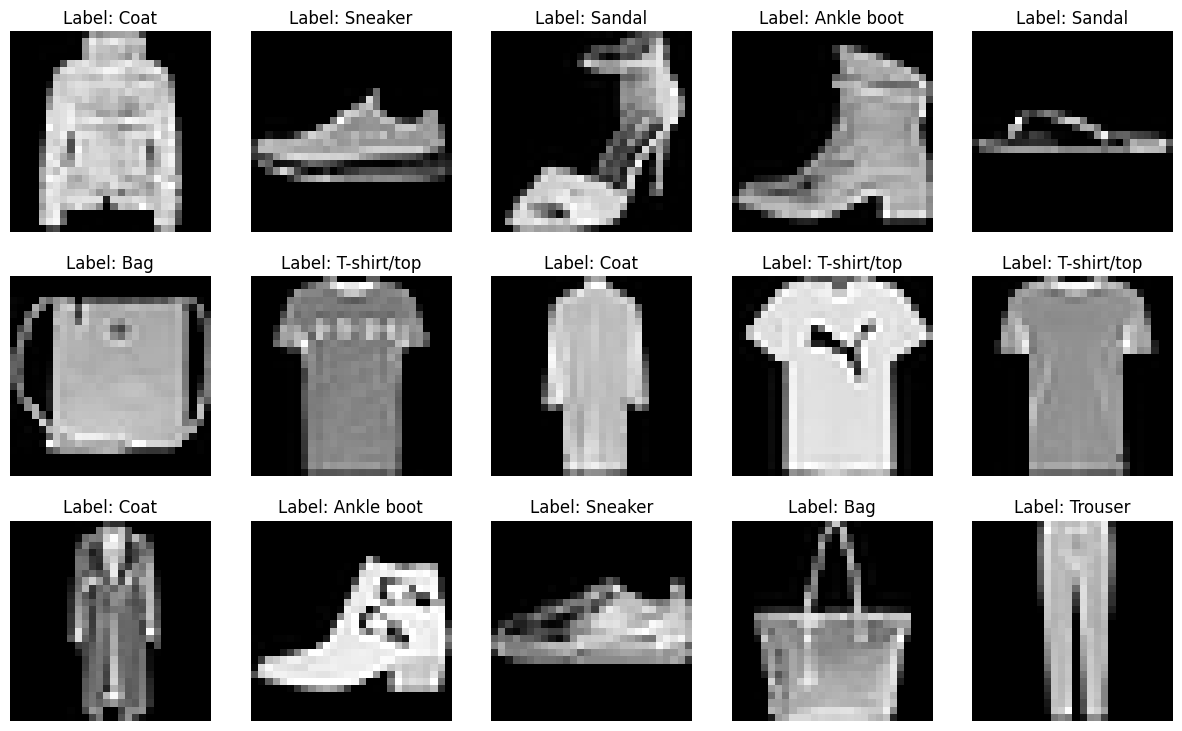

In [9]:
show_random_images(trn_data, labels_str= trn_data.classes, n= 15)

### Create Train & Test DataLoader

In [10]:
BATCH_SIZE = 32
trn_loader = DataLoader(trn_data, batch_size= BATCH_SIZE, shuffle= True)
tst_loader = DataLoader(tst_data, batch_size= BATCH_SIZE, shuffle= False)

### Define a Simple Feedforward Network

In [11]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) # 10-class classification
        self.dropout = nn.Dropout(.5) # Kills half the weights

    def forward(self, x):
        x = x.view(-1, 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        return self.fc3(x)

### Train & Evaluate the Model

In [12]:
def train_model_with_early_stopping(model, trn_loader, tst_loader, device, epochs= 10, patience= 5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= .001)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience= 3, verbose= True)

    loss_bst = float('inf')
    patience_counter = 0

    trn_loss_lst, tst_loss_lst = [], []
    trn_acc_lst, tst_acc_lst = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        trn_loss, trn_correct = 0, 0

        for images, labels in trn_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            trn_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            trn_correct += (preds == labels).sum().item()

        trn_accuracy = 100 * trn_correct / len(trn_loader.dataset)
        trn_loss_avg = trn_loss / len(trn_loader)
        trn_loss_lst.append(trn_loss_avg)
        trn_acc_lst.append(trn_accuracy)

        model.eval()
        tst_loss, tst_correct, tst_total = 0, 0, 0
        with torch.inference_mode():
            for images, labels in tst_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                tst_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                tst_correct += (preds == labels).sum().item()
                tst_total += labels.size(0)

        tst_accuracy = 100 * tst_correct / tst_total
        tst_loss_avg = tst_loss / len(tst_loader)
        tst_loss_lst.append(tst_loss_avg)
        tst_acc_lst.append(tst_accuracy)

        # Print the stat for every epoch:
        print(
            f'Epoch [{epoch}/{epochs}] => '
            f'Train Loss: {trn_loss_avg:.4f} - Train Acc: {trn_accuracy:.2f}% | '
            f'Test Loss: {tst_loss_avg:.4f} - Test Acc: {tst_accuracy:.2f}%'
        )

        lr_scheduler.step(tst_loss_avg)

        if tst_loss_avg < loss_bst:
            loss_bst = tst_loss_avg
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch} ...')
            break
    return trn_loss_lst, tst_loss_lst, trn_acc_lst, tst_acc_lst

In [13]:
def plot_metrics(trn_losses, tst_losses, trn_acc, tst_acc):
    """
    Plot Loss and accuracy curves.
    """
    epochs = range(1, len(trn_losses) + 1)
    fig, axs = plt.subplots(1, 2, figsize= (15, 5))

    ax = axs[0]
    ax.plot(epochs, trn_losses, label= 'Train Loss')
    ax.plot(epochs, tst_losses, label= 'Test Loss')
    ax.set_title('Loss Curves')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_xticks(epochs)

    ax = axs[1]
    ax.plot(epochs, trn_acc, label= 'Train Acc')
    ax.plot(epochs, tst_acc, label= 'Test Acc')
    ax.set_title('Accuracy Curves')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.set_xticks(epochs)

    plt.show()

In [14]:
def evaluate_and_get_misclassified(model, data_loader, device):
    """
    Evaluate the model & get the misclassified examples.
    """
    model.to(device)
    model.eval()
    misclassified = []

    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified.append((img.cpu(), label.cpu(), pred.cpu()))
    acc = 100 * correct / total
    print(f'Accuracy: {acc:.2f}%')
    return misclassified


In [15]:
def show_misclassified(misclassified, labels_str, n):
    """
    Visualizing Misclassified Examples
    """
    indices = np.random.choice(len(misclassified), n, replace= False)
    # Limit the number of columns to 5
    cols = 5
    rows = (n + 4) // cols

    fig, axes = plt.subplots(rows, cols, figsize= (15, 3 * rows))
    for i, idx in enumerate(indices):
        img, label_true, label_pred = misclassified[idx]
        ax = axes[i // cols, i % cols]
        ax.imshow(img.squeeze(), cmap= 'gray')
        ax.set_title(f'{labels_str[label_true]},\nPredicted: {labels_str[label_pred]}')
        ax.axis('off')
    plt.show()

In [16]:
def top_mistaken_labels(misclassified, n):
    """
    Finds Top n Mistaken Labels.
    """
    #@TODO: fix this bug: [((6, 0), 223), ((2, 4), 100), ((4, 2), 91)]
    # (2, 4) & (4, 2) are the same misclassification for this purposes.
    pairs = [(label_true.item(), label_pred.item()) for _, label_true, label_pred in misclassified]
    counter = Counter(pairs)
    return counter.most_common(n)


In [17]:
# Set up device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [18]:
# Train the model with early stopping
model = SimpleNN()
trn_losses, tst_losses, trn_acc, tst_acc = train_model_with_early_stopping(model,
                                                                           trn_loader,
                                                                           tst_loader,
                                                                           device= device,
                                                                           epochs= 20,
                                                                           patience= 3)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/20] => Train Loss: 0.6640 - Train Acc: 76.07% | Test Loss: 0.4619 - Test Acc: 82.92%
Epoch [2/20] => Train Loss: 0.5242 - Train Acc: 81.46% | Test Loss: 0.4349 - Test Acc: 84.25%
Epoch [3/20] => Train Loss: 0.4907 - Train Acc: 82.53% | Test Loss: 0.4120 - Test Acc: 84.71%
Epoch [4/20] => Train Loss: 0.4714 - Train Acc: 83.44% | Test Loss: 0.4129 - Test Acc: 85.30%
Epoch [5/20] => Train Loss: 0.4607 - Train Acc: 83.68% | Test Loss: 0.4123 - Test Acc: 84.87%
Epoch [6/20] => Train Loss: 0.4514 - Train Acc: 83.90% | Test Loss: 0.3927 - Test Acc: 85.89%
Epoch [7/20] => Train Loss: 0.4409 - Train Acc: 84.35% | Test Loss: 0.3787 - Test Acc: 86.17%
Epoch [8/20] => Train Loss: 0.4324 - Train Acc: 84.61% | Test Loss: 0.3918 - Test Acc: 85.92%
Epoch [9/20] => Train Loss: 0.4248 - Train Acc: 84.96% | Test Loss: 0.3919 - Test Acc: 85.61%
Epoch [10/20] => Train Loss: 0.4254 - Train Acc: 84.84% | Test Loss: 0.3848 - Test Acc: 86.02%
Early stopping at epoch 10 ...


In [19]:
torch.save(model.state_dict(), 'fmnist_ff.ph')

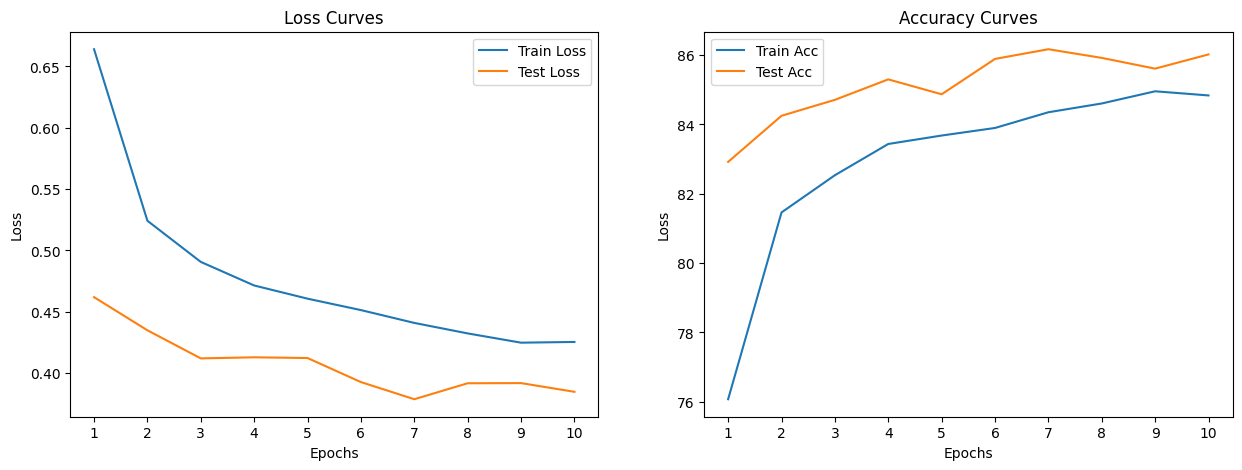

In [20]:
plot_metrics(trn_losses, tst_losses, trn_acc, tst_acc)

Accuracy: 86.02%


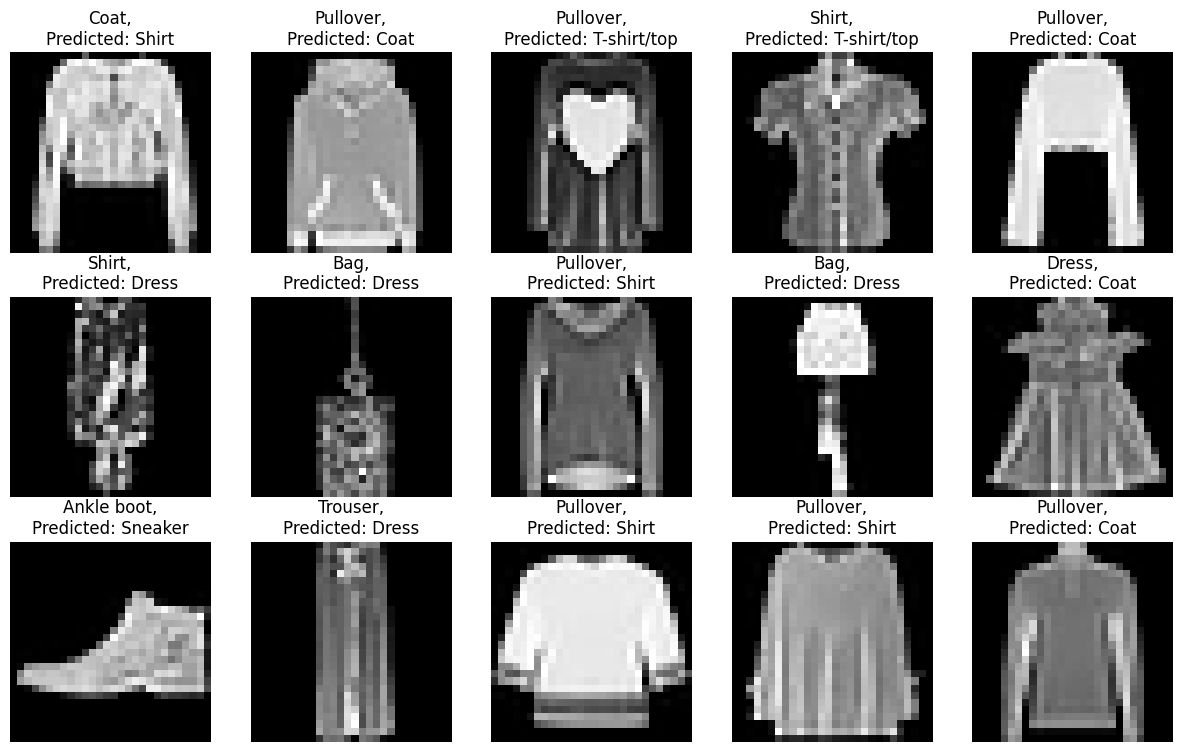

In [21]:
# Evaluate on test data and visualize sample misclassified examples:
misclassified = evaluate_and_get_misclassified(model, tst_loader, device)
show_misclassified(misclassified, trn_data.classes, 15)

In [22]:
# Find top 3 mistaken labels
mistaken_labels = top_mistaken_labels(misclassified, 3)
print('Most mistaken categories are:')
print(mistaken_labels)

Most mistaken categories are:
[((2, 4), 145), ((6, 0), 122), ((6, 4), 106)]


In [23]:
trn_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Transfer Leaerning using EfficientNet

In [24]:
# len(train_loader.dataset)
# instead of trn_total += ...
# simply:
# train_accuracy = 100 * train_correct / len(train_loader.dataset)

In [25]:
transform_effnet = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [27]:
# The FashionMNIST dataset has grayscale images (1 channel)
# while the EfficientNet model expects 3-channel RGB images.
# We need to adjust the transformations to convert the grayscale images to RGB
# (by duplicating the single channel three times.)
class GrayToRGB:
    def __call__(self, img):
        return img.convert('RGB')

In [28]:
transforms_effnet_b0 = transforms.Compose([
    GrayToRGB(),
    weights.transforms(),
])

transforms_effnet_b0

Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [29]:
trn_data_effnet = datasets.FashionMNIST(root= 'data', train= True, transform= transforms_effnet_b0)
tst_data_effnet = datasets.FashionMNIST(root= 'data', train= False, transform= transforms_effnet_b0)

trn_loader_effnet = DataLoader(trn_data_effnet, batch_size= BATCH_SIZE, shuffle= True)
tst_loader_effnet = DataLoader(tst_data_effnet, batch_size= BATCH_SIZE, shuffle= False)

In [30]:
model = torchvision.models.efficientnet_b0(weights= weights).to(device)

In [31]:
for param in model.features.parameters():
    # Freeze the parameters of the `features` layer
    param.requires_grad = False

In [32]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [33]:
trn_data_effnet.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [34]:
# Update the `classifier` layer to suit our problem:
torch.manual_seed(1)
torch.cuda.manual_seed(1)

model.classifier = nn.Sequential(
    nn.Dropout(p= .2, inplace= True),
    nn.Linear(in_features= 1280, out_features= len(trn_data_effnet.classes))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [35]:
# Train the model with early stopping
trn_losses2, tst_losses2, trn_acc2, tst_acc2 = train_model_with_early_stopping(model,
                                                                               trn_loader_effnet,
                                                                               tst_loader_effnet,
                                                                               device,
                                                                               epochs= 10,
                                                                               patience= 3)

Epoch [1/10] => Train Loss: 0.6243 - Train Acc: 79.42% | Test Loss: 0.4412 - Test Acc: 84.95%
Epoch [2/10] => Train Loss: 0.4956 - Train Acc: 82.64% | Test Loss: 0.4232 - Test Acc: 85.38%
Epoch [3/10] => Train Loss: 0.4729 - Train Acc: 83.33% | Test Loss: 0.3986 - Test Acc: 85.86%
Epoch [4/10] => Train Loss: 0.4649 - Train Acc: 83.47% | Test Loss: 0.3977 - Test Acc: 86.45%
Epoch [5/10] => Train Loss: 0.4613 - Train Acc: 83.74% | Test Loss: 0.4005 - Test Acc: 86.10%
Epoch [6/10] => Train Loss: 0.4594 - Train Acc: 83.60% | Test Loss: 0.3910 - Test Acc: 86.26%
Epoch [7/10] => Train Loss: 0.4605 - Train Acc: 83.66% | Test Loss: 0.3997 - Test Acc: 86.00%
Epoch [8/10] => Train Loss: 0.4577 - Train Acc: 83.66% | Test Loss: 0.3917 - Test Acc: 86.49%
Epoch [9/10] => Train Loss: 0.4547 - Train Acc: 83.75% | Test Loss: 0.3872 - Test Acc: 86.72%
Epoch [10/10] => Train Loss: 0.4599 - Train Acc: 83.46% | Test Loss: 0.3880 - Test Acc: 86.24%


In [36]:
torch.save(model.state_dict(), 'fmnist_tl.ph')

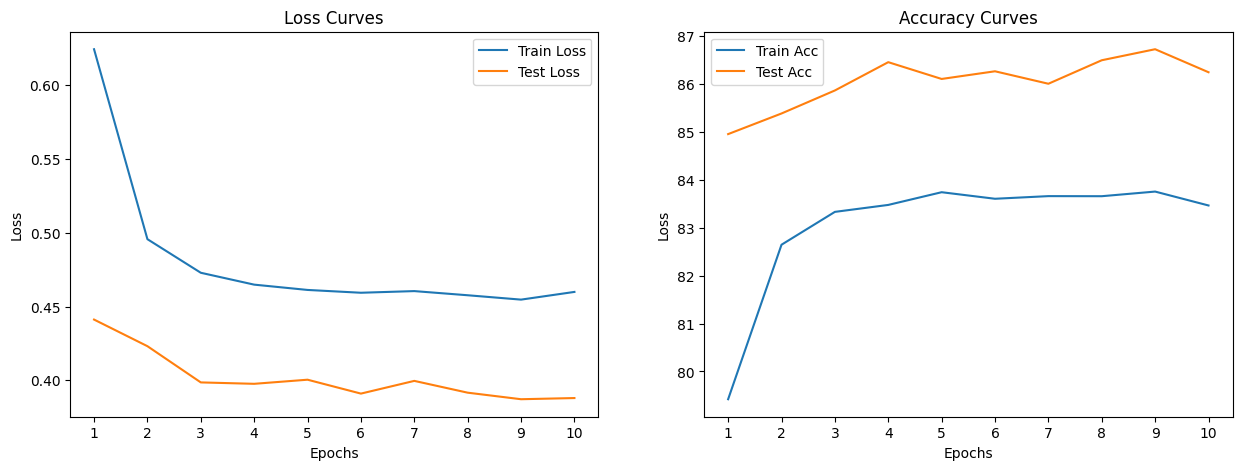

In [37]:
plot_metrics(trn_losses2, tst_losses2, trn_acc2, tst_acc2)

In [38]:
def show_misclassified(misclassified, labels_str, n):
    """
    Visualizing Misclassified Examples
    """
    indices = np.random.choice(len(misclassified), n, replace=False)
    # Limit the number of columns to 5
    cols = 5
    rows = (n + 4) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, idx in enumerate(indices):
        img, label_true, label_pred = misclassified[idx]

        # Handle different image shapes
        if img.shape[0] == 3:  # Color channel first (e.g., (3, 224, 224))
            img = np.transpose(img, (1, 2, 0))
        elif img.shape[-1] == 3:  # Color channel last (e.g., (224, 224, 3))
            img = img
        elif len(img.shape) == 2:  # Grayscale (e.g., (224, 224))
            img = np.expand_dims(img, axis=-1)
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        ax = axes[i // cols, i % cols]
        if img.shape[-1] == 1:  # If grayscale, remove the last dimension
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img)

        ax.set_title(f'{labels_str[label_true]},\nPredicted: {labels_str[label_pred]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Accuracy: 86.24%


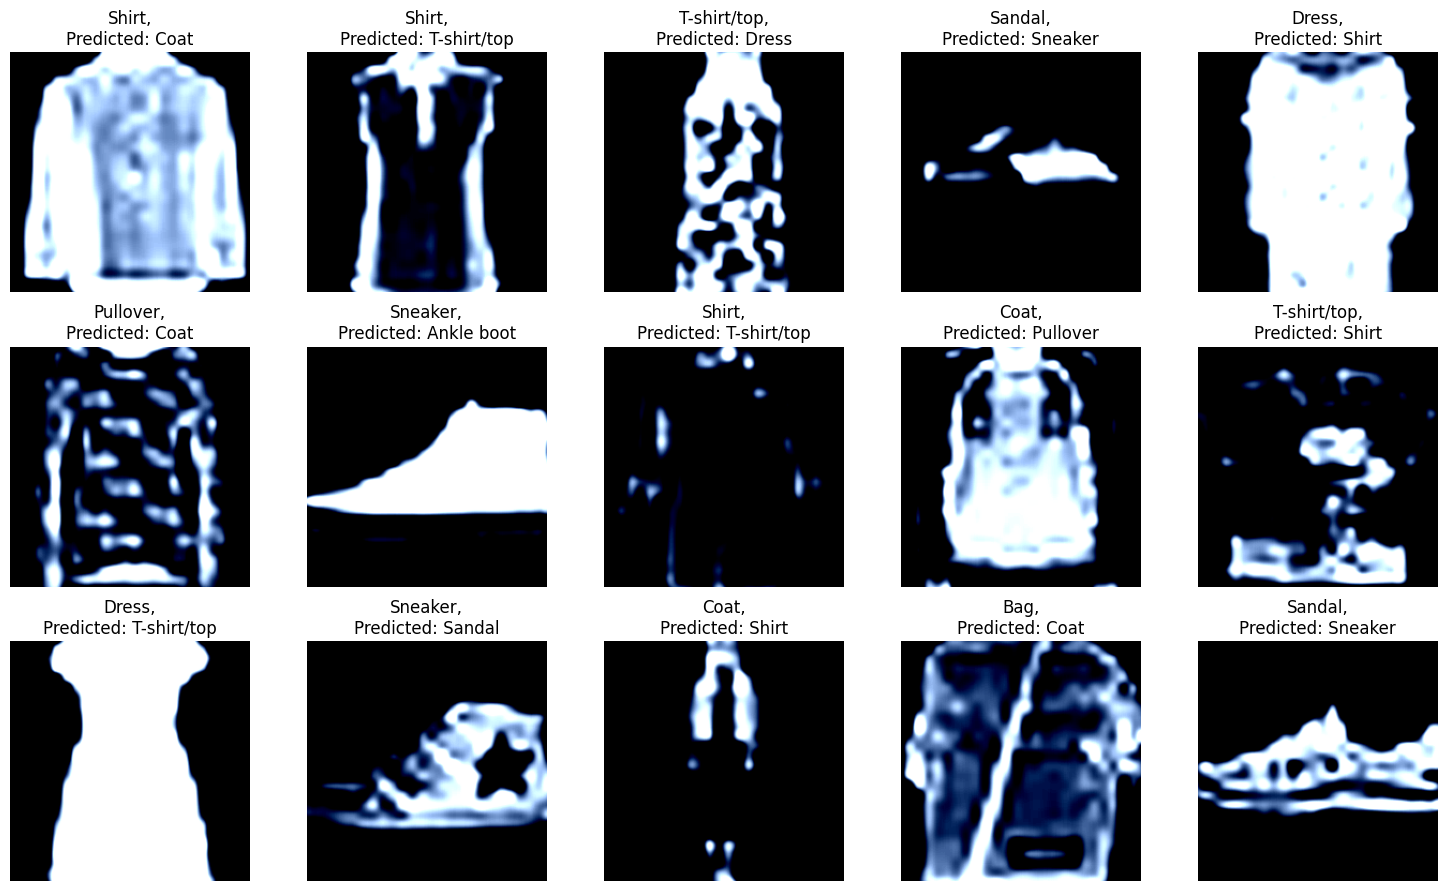

In [39]:
# Evaluate on test data and visualize sample misclassified examples:
misclassified2 = evaluate_and_get_misclassified(model, tst_loader_effnet, device)
show_misclassified(misclassified2, trn_data_effnet.classes, 15)

In [40]:
trn_data_effnet.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [41]:
# Find top 3 mistaken labels
mistaken_labels2 = top_mistaken_labels(misclassified2, 3)
print('Most mistaken categories are:')
print(mistaken_labels2)

Most mistaken categories are:
[((6, 0), 169), ((6, 4), 112), ((4, 6), 107)]


In [42]:
#@Todo: save the trained models for future use

In [43]:
type(misclassified)

list

In [44]:
import pickle

# Save to a binary file using pickle
with open('misclassified_ff.pkl', 'wb') as f:
    pickle.dump(misclassified, f)



In [45]:
with open('misclassified_tl.pkl', 'wb') as f:
    pickle.dump(misclassified2, f)